# Library import

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, accuracy_score

import sys

# from google.colab import drive # delete this line if not used on colab
# drive.mount("/content/drive", force_remount = True) # delete this line if not used on colab

# sys.path.append("C:/Users/Walraff/OneDrive - Universite de Liege/Documents/Ulg/Master2/TFE/")
# sys.path.append("/content/drive/MyDrive/TFE/")
import utils

import wandb

In [3]:
# data_path = "C:/Users/Walraff/OneDrive - Universite de Liege/Documents/Ulg/Master2/TFE/data"
# data_path = "/content/drive/MyDrive/TFE"
data_path = "/home/jwalraff/TFE/data"
original_df = pd.read_csv(f'{data_path}/final_status_SPARE.csv')
original_df

,ProteinName_SPARE,Peptide_SPARE,Status_SPARE
0,sp|P02751|FINC_HUMAN,VDVIPVNLPGEHGQR,bon
1,sp|P02751|FINC_HUMAN,STTPDITGYR,bon
2,sp|P02751|FINC_HUMAN,SYTITGLQPGTDYK,bon
3,sp|P02751|FINC_HUMAN,IYLYTLNDNAR,bon
4,sp|P04114|APOB_HUMAN,TGISPLALIK,bon
...,...,...,...
150,sp|P02743|SAMP_HUMAN,VGEYSLYIGR,bon
151,sp|P04004|VTNC_HUMAN,GQYCYELDEK,mauvais
152,sp|P04004|VTNC_HUMAN,FEDGVLDPDYPR,bon
153,sp|P04004|VTNC_HUMAN,DWHGVPGQVDAAMAGR,bon


In [4]:
data_human_unique_peptide_path = f'{data_path}/Tryptic unique peptide of the human proteome.csv'
data_human_unique_peptide = pd.read_csv(data_human_unique_peptide_path, delimiter = ";")
data_human_unique_peptide

,Peptide,Protein,Peptide Modified Sequence,Standard Type,First Position,Last Position,Missed Cleavages,Predicted Retention Time,Average Measured Retention Time,Peptide Note
0,MQLVQESEEK,sp|A0A0B4J2F0|PIOS1_HUMAN,MQLVQESEEK,NaN,43,52,0,NaN,NaN,NaN
1,QPCLPIWHEMVETGGSEGVVR,sp|A0A0K2S4Q6|CD3CH_HUMAN,QPC[+57]LPIWHEMVETGGSEGVVR,NaN,59,79,0,NaN,NaN,NaN
2,VPLLLSILGAILWVNRPWR,sp|A0A0K2S4Q6|CD3CH_HUMAN,VPLLLSILGAILWVNRPWR,NaN,177,195,0,NaN,NaN,NaN
3,SHPPPPEK,sp|A0A0U1RRE5|NBDY_HUMAN,SHPPPPEK,NaN,61,68,0,NaN,NaN,NaN
4,SVSLLRPPFSQLPSK,sp|A0A1B0GTW7|CIROP_HUMAN,SVSLLRPPFSQLPSK,NaN,31,45,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
365085,ELNQYFELAK,sp|Q9Y3F1|TA6P_HUMAN,ELNQYFELAK,NaN,44,53,0,NaN,NaN,NaN
365086,GSFLIWLLLCWNSWYHLR,sp|Q9Y6C7|L3R2A_HUMAN,GSFLIWLLLC[+57]WNSWYHLR,NaN,36,53,0,NaN,NaN,NaN
365087,LCHGDSELTSGLLAT,sp|Q9Y6C7|L3R2A_HUMAN,LC[+57]HGDSELTSGLLAT,NaN,80,94,0,NaN,NaN,NaN
365088,SCQIEQVK,sp|Q9Y6Z2|CF123_HUMAN,SC[+57]QIEQVK,NaN,32,39,0,NaN,NaN,NaN


# Dataset, model and loading data

In [ ]:
# Define the vocabulary
amino_acid_vocab = {aa: idx+1 for idx, aa in enumerate("ACDEFGHIKLMNPQRSTVWY")}

class PeptideDataset(Dataset):
    def __init__(self, sequences, labels, pseudo_labels, vocab, max_len):
        """
        Dataset for peptide sequences.

        Args:
            sequences (list of str): List of amino acid sequences.
            labels (list of int): List of labels associated with the sequences.
            pseudo_labels (list of int): List of pseudo labels associated with the sequences.
            vocab (dict): Mapping dictionary {amino acid: index}.
            max_len (int): Maximum sequence length (applies padding).
        """
        self.sequences = sequences
        self.labels = labels
        self.vocab = vocab
        self.max_len = max_len
        self.pseudo_labels = pseudo_labels

    def encode_sequence(self, sequence):
        """Encodes a sequence into integer indices with padding."""
        encoded = [self.vocab.get(aa, 0) for aa in sequence]  # Encodage
        encoded += [0] * (self.max_len - len(encoded))  # Padding
        return torch.tensor(encoded, dtype=torch.long)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        """Returns an encoded sequence, its label and the pseudo label."""
        sequence = self.sequences[idx]
        label = self.labels[idx]
        pseudo_label = self.pseudo_labels[idx]
        encoded_sequence = self.encode_sequence(sequence)
        return encoded_sequence, torch.tensor(label, dtype=torch.float32), pseudo_label


In [ ]:
# Creating a dataframe with the sequences and labels
df = pd.DataFrame()
df["sequence"] = original_df["Peptide_SPARE"]
df["quantotypic"] = original_df.apply(lambda row: 0 if row['Status_SPARE'] == 'bon' else 1, axis=1)

positive_df = df[df['quantotypic'] == 0]
negative_df = df[df['quantotypic'] == 1]

class_counts = df['quantotypic'].value_counts()
max_len = df['sequence'].str.len().max()
print(class_counts)

quantotypic
0    117
1     38
Name: count, dtype: int64


In [7]:
dataset = PeptideDataset(df["sequence"].values, df["quantotypic"].values, df["pseudo_label"].values, amino_acid_vocab, max_len)
loader = DataLoader(dataset, batch_size = 2, shuffle=True)

In [8]:
for batch in loader:
    print(batch)

[tensor([[18, 12,  4, 13, 16,  8, 10,  4, 11, 16, 15,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0],
        [10, 18, 13,  5,  1, 17,  4, 10,  7,  4, 15,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0]]), tensor([0., 0.]), tensor([False, False])]
[tensor([[16, 17, 17, 13,  3,  8, 17,  6, 20, 15,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0],
        [10, 16, 20, 17,  2,  4,  6,  6,  5, 15,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0]]), tensor([0., 0.]), tensor([False, False])]
[tensor([[ 5, 18, 20,  7, 10, 16,  3, 10,  2,  9,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0],
        [10,  6, 16, 10,  6,  1,  1,  2,  4, 14, 17, 14, 17,  4,  6,  1,  9,  0,
          0,  0,  0]]), tensor([0., 1.]), tensor([False, False])]
[tensor([[ 8, 10,  6, 13, 10, 16, 20, 16,  9,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0],
        [10, 17, 13, 20,  1,  3,  4,  5,  9,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0]]), tensor([0., 0.]), tensor([False, False

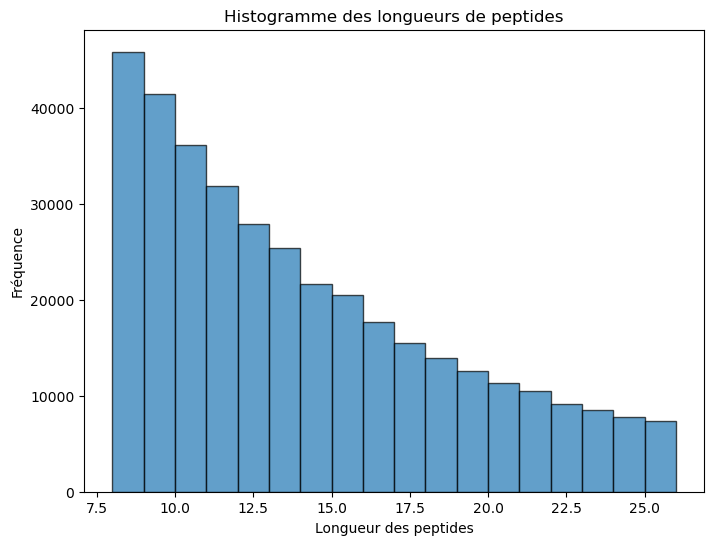

In [ ]:
peptide_lengths = data_human_unique_peptide["Peptide"].apply(len)

plt.figure(figsize=(8, 6))
plt.hist(peptide_lengths, bins=np.arange(peptide_lengths.min(), peptide_lengths.max() + 2, 1), edgecolor='black', alpha=0.7)
plt.xlabel("Longueur des peptides")
plt.ylabel("Fréquence")
plt.title("Histogramme des longueurs de peptides")
plt.show()
plt.close()

In [10]:
unique_peptide = data_human_unique_peptide["Peptide"]
filtering_self_training = unique_peptide.apply(len) <= max_len
unique_peptide = unique_peptide[filtering_self_training].reset_index(drop=True)
unique_peptide = unique_peptide.drop_duplicates(ignore_index = True)
unique_peptide

0                    MQLVQESEEK
1         QPCLPIWHEMVETGGSEGVVR
2           VPLLLSILGAILWVNRPWR
3                      SHPPPPEK
4               SVSLLRPPFSQLPSK
                  ...          
331077               ELNQYFELAK
331078       GSFLIWLLLCWNSWYHLR
331079          LCHGDSELTSGLLAT
331080                 SCQIEQVK
331081       YSVPDTGLFQHWEGSIPT
Name: Peptide, Length: 331082, dtype: object

In [ ]:
class PeptideBiLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, lstm_hidden_dim, output_dim, dropout_prob, num_layers):
        """
        Bidirectional LSTM-based classifier for peptide sequences.

        Args:
            vocab_size (int): Size of the vocabulary (number of amino acid + padding).
            embed_dim (int): Size of the embedding vectors.
            hidden_dim (int): Number of units in the fully connected hidden layer.
            lstm_hidden_dim (int): Number of hidden units in the BiLSTM.
            output_dim (int): Number of output classes (1 here).
            dropout_prob (float): Dropout rate applied after the first fully connected layer.
            num_layers (int): Number of LSTM layers.
        """
        super(PeptideBiLSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.bilstm = nn.LSTM(embed_dim, lstm_hidden_dim, num_layers=num_layers,
                              bidirectional=True, batch_first=True, dropout=dropout_prob)
        self.fc1 = nn.Linear(2 * lstm_hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        # Embed input sequences
        embedded = self.embedding(x)  # (batch_size, max_seq_len, embed_dim)

        # BiLSTM encoding
        lstm_out, _ = self.bilstm(embedded)  # (batch_size, max_seq_len, 2 * lstm_hidden_dim)

        # Use the output of the last time step
        lstm_out_last = lstm_out[:, -1, :]  # (batch_size, 2 * lstm_hidden_dim)

        # Fully connected layers with dropout
        hidden = F.relu(self.fc1(lstm_out_last))
        hidden = self.dropout(hidden)
        output = self.fc2(hidden)  # (batch_size, output_dim)

        return output

# Functions

In [ ]:
def early_stopping(val_losses, patience):
    """
    Checks if the last 'patience' validation losses have increased or remained the same.

    Args:
        val_losses (list): List of validation losses.
        patience (int): Number of consecutive epochs to check for lack of improvement.

    Returns:
        bool: True if the last 'patience' losses show no improvement, otherwise False.
    """
    # Not enough values to apply the early stopping criterion
    if len(val_losses) < patience + 1:
        return False

    # Check if each of the last 'patience' losses is greater than or equal to the previous one
    for i in range(-patience, -1):
        if val_losses[i] < val_losses[i + 1]:
            continue
        else:
            return False

    return True

In [ ]:
def reordering(data, labels, batch_converter, device):
    """
    Prepares and converts a batch of sequence data and labels for ESM-2 model input.

    Args:
        data (tuple): Tuple containing two lists (e.g., sequence names and sequences).
        labels (torch.Tensor): Tensor of labels associated with each sequence.
        batch_converter (callable): Function to convert (name, sequence) pairs into tokenized format.
        device (torch.device): Device to move the tensors to (e.g., 'cuda' or 'cpu').

    Returns:
        tuple:
            - batch_tokens (torch.Tensor): Tensor of tokenized sequences.
            - batch_labels (torch.Tensor): Tensor of corresponding labels (shape: [batch_size]).
    """
    # Reformat data into a list of (name, sequence) tuples
    ReArrangeData = []
    for i in range(len(data[0])):
        ReArrangeData.append((data[0][i], data[1][i]))

    # Move labels to device and ensure float format
    labels = labels.float()
    batch_labels = labels.to(device).unsqueeze(1)

    # Convert sequences to tokens using the batch converter
    batch_tokens = batch_converter(ReArrangeData)[2].to(device)

    return batch_tokens, batch_labels.squeeze(1)

def train_epoch(model, dataloader, optimizer, criterion, device,
                model_name='Scratch', batch_converter=None,
                use_double_loss=False, alpha=1.0):
    """
    Trains the model for one epoch.

    Args:
        model (nn.Module): Model to train.
        dataloader (DataLoader): DataLoader providing the training data.
        optimizer (torch.optim.Optimizer): Optimizer for model updates.
        criterion (nn.Module): Loss function.
        device (str): Device to use ('cuda' or 'cpu').
        model_name (str, optional): Model type ('Scratch', 'ESM', 'RT', 'CCS'). Defaults to 'Scratch'.
        batch_converter (callable, optional): Batch converter function for 'ESM'. Defaults to None.
        use_double_loss (bool, optional): If True, computes separate losses for real and pseudo-labeled samples. Defaults to False.
        alpha (float, optional): Weighting factor for pseudo-label loss if use_double_loss is enabled. Defaults to 1.0.

    Returns:
        float: Mean loss for the epoch.
    """
    model.train()
    train_losses = []

    for batch in dataloader:
        if model_name == 'ESM':
            X, y = batch
            X, y = reordering(X, y, batch_converter, device)
        elif model_name in ['RT', 'CCS']:
            aa_idx, mod_x, y = batch
            aa_idx, mod_x, y = aa_idx.to(device), mod_x.to(device), y.to(device)
        else:
            # For 'Scratch' model: batch contains X, y, and ps (pseudo-label indicator)
            X, y, ps = batch
            X, y, ps = X.to(device), y.to(device), ps.to(device)

        optimizer.zero_grad()

        # Forward pass
        if model_name in ['RT', 'CCS']:
            output = model(aa_idx, mod_x).squeeze(1)
        else:
            output = model(X).squeeze(1)

        # Compute loss
        if use_double_loss and model_name not in ['ESM', 'RT', 'CCS']:
            real_mask = ~ps  # Real labels
            pseudo_mask = ps  # Pseudo-labels

            loss_real = criterion(output[real_mask], y[real_mask]) if real_mask.sum() > 0 else 0.0
            loss_pseudo = criterion(output[pseudo_mask], y[pseudo_mask]) if pseudo_mask.sum() > 0 else 0.0
            loss = loss_real + alpha * loss_pseudo
        else:
            loss = criterion(output, y)

        # Backward pass and weight update
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    return np.array(train_losses).mean()

def val_epoch(model, dataloader, criterion, device, threshold=0.5,
              model_name='Scratch', batch_converter=None,
              use_double_loss=False, alpha=1.0):
    """
    Evaluates the model on the validation set for one epoch and computes additional metrics.

    Args:
        model (nn.Module): Model to evaluate.
        dataloader (DataLoader): DataLoader providing validation data.
        criterion (nn.Module): Loss function.
        device (str): Device to use ('cuda' or 'cpu').
        threshold (float, optional): Threshold for binary classification. Defaults to 0.5.
        model_name (str, optional): Type of model ('Scratch', 'ESM', 'RT', 'CCS'). Defaults to 'Scratch'.
        batch_converter (callable, optional): Batch converter function for 'ESM'. Defaults to None.
        use_double_loss (bool, optional): If True, computes separate losses for real labels and pseudo-labels. Defaults to False.
        alpha (float, optional): Weighting factor for pseudo-label loss if use_double_loss is enabled. Defaults to 1.0.

    Returns:
        dict: Dictionary containing:
              - "loss": Mean validation loss.
              - "accuracy": Accuracy score.
              - "roc_auc": ROC AUC score.
              - "pr_auc": Precision-Recall AUC score.
    """
    model.eval()
    val_losses = []
    all_targets = []
    all_predictions = []
    all_probabilities = []

    with torch.no_grad():
        for batch in dataloader:
            if model_name == 'ESM':
                X, y = batch
                X, y = reordering(X, y, batch_converter, device)
            elif model_name in ['RT', 'CCS']:
                aa_idx, mod_x, y = batch
                aa_idx, mod_x, y = aa_idx.to(device), mod_x.to(device), y.to(device)
            else:
                # For 'Scratch' model, batch may include pseudo-labels
                if use_double_loss:
                    X, y, ps = batch
                    X, y, ps = X.to(device), y.to(device), ps.to(device)
                else:
                    X, y, _ = batch
                    X, y = X.to(device), y.to(device)

            # Forward pass
            if model_name in ['RT', 'CCS']:
                output = model(aa_idx, mod_x).squeeze(1)
            else:
                output = model(X).squeeze(1)

            probabilities = torch.sigmoid(output)

            # Loss calculation
            if use_double_loss and model_name not in ['ESM', 'RT', 'CCS']:
                real_mask = ~ps
                pseudo_mask = ps

                loss_real = criterion(output[real_mask], y[real_mask]) if real_mask.sum() > 0 else 0.0
                loss_pseudo = criterion(output[pseudo_mask], y[pseudo_mask]) if pseudo_mask.sum() > 0 else 0.0
                loss = loss_real + alpha * loss_pseudo
            else:
                loss = criterion(output, y)

            val_losses.append(loss.item())

            # Convert probabilities to binary predictions
            binary_output = (probabilities >= threshold).float()

            all_targets.extend(y.cpu().numpy())
            all_predictions.extend(binary_output.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())

    mean_loss = np.array(val_losses).mean()
    accuracy = (np.array(all_predictions) == np.array(all_targets)).mean()
    roc_auc = roc_auc_score(all_targets, all_probabilities) if len(np.unique(all_targets)) > 1 else 0.0
    pr_auc = average_precision_score(all_targets, all_probabilities) if len(np.unique(all_targets)) > 1 else 0.0

    return {
        "loss": mean_loss,
        "accuracy": accuracy,
        "roc_auc": roc_auc,
        "pr_auc": pr_auc
    }

In [ ]:
def train(model, train_loader, val_loader, n_epochs, lr, threshold=0.5, do_early_stopping=True, model_name='Scratch', batch_converter=None, weight=None, verbose=False, use_double_loss=False, alpha=1.0):
    """
    Train the model and validate at each epoch.

    Args:
        model (nn.Module): The instance of the model to train.
        train_loader (Dataloader): Dataloader providing the training data.
        val_loader (Dataloader): Dataloader providing the validation data.
        n_epochs (int): The number of epochs to train.
        lr (float): Learning rate for the optimizer.
        filename (str): Name of the file to save the final model.
        threshold (float, optional): Threshold for binary classification. Defaults to 0.5.
        do_early_stopping (bool, optional): Whether to apply early stopping. Defaults to True.
        model_name (str, optional): Identifier for model type (e.g., 'Scratch', 'ESM', 'RT', 'CCS').
        batch_converter (callable, optional): Function to convert ESM batches into token format.
        weight (torch.Tensor, optional): Weight for positive class in BCEWithLogitsLoss.
        verbose (bool, optional): If True, prints training progress. Defaults to False.

    Returns:
        dict: Training history containing:
            - "train_loss": List of training losses per epoch.
            - "val_loss": List of validation losses per epoch.
            - "val_accuracy": List of validation accuracies.
            - "val_roc_auc": List of ROC-AUC scores.
            - "val_pr_auc": List of PR-AUC scores.
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    # print(f"device = {device}")
    torch.cuda.empty_cache()
    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    if weight is not None:
        criterion = nn.BCEWithLogitsLoss(pos_weight=weight)
    else:
        criterion = nn.BCEWithLogitsLoss()

    history = {
        "train_loss": [],
        "val_loss": [],
        "val_accuracy": [],
        "val_roc_auc": [],
        "val_pr_auc": [],
    }

    for epoch in range(n_epochs):
        if verbose:
            print(f"\n--- Epoch {epoch + 1}/{n_epochs} ---")

        # Training epoch
        train_loss = train_epoch(model, train_loader, optimizer, criterion, device, model_name=model_name, batch_converter=batch_converter,
                                use_double_loss=use_double_loss, alpha=alpha)

        # Validation epoch
        val_metrics = val_epoch(model, val_loader, criterion, device, threshold, model_name=model_name, batch_converter=batch_converter,
                               use_double_loss=use_double_loss, alpha=alpha)

        # Save metrics to history
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_metrics["loss"])
        history["val_accuracy"].append(val_metrics["accuracy"])
        history["val_roc_auc"].append(val_metrics["roc_auc"])
        history["val_pr_auc"].append(val_metrics["pr_auc"])

        # Early stopping
        if early_stopping(history["val_loss"], patience=5) and do_early_stopping:
            print(f"Early stopping triggered at {epoch} epoch.")
            break

    # wandb.log({"Early_stopping": epoch})

    return history

In [ ]:
def compute_pos_weight(df, target_column):
    """
    Computes the pos_weight value for BCEWithLogitsLoss based on class imbalance.

    Args:
        df (pd.DataFrame): DataFrame containing the target labels.
        target_column (str): Name of the column with binary class labels.

    Returns:
        torch.Tensor: A tensor representing the positive class weight for use in BCEWithLogitsLoss.
                      If no positive samples are found, defaults to a weight of 1.0.
    """
    class_counts = df[target_column].value_counts()

    num_pos = class_counts.get(1, 0)  # Number of positive samples
    num_neg = class_counts.get(0, 0)  # Number of negative samples

    if num_pos == 0:
        pos_weight = torch.tensor(1.0, dtype=torch.float64)
    else:
        pos_weight = torch.tensor(num_neg / num_pos, dtype=torch.float64)

    return pos_weight

compute_pos_weight(df, 'quantotypic')

tensor(3.0789, dtype=torch.float64)

In [ ]:
def compute_best(history, best_history, model, best_model):
    """
    Compares the current model with the best model based on the 'pr_auc' or 'val_pr_auc' metric.

    Args:
        history (dict): Dictionary containing training and validation metrics of the current model.
        best_history (dict): Dictionary containing the best model's validation metrics so far.
        model (nn.Module): Current model.
        best_model (nn.Module): Previously saved best model.

    Returns:
        tuple:
            - best_model (nn.Module): Updated best model if the current model is better.
            - best_history (dict): Updated best history if the current model is better.
            - Better (bool): True if the current model outperformed the previous best.
    """
    
    def extract_metric_value(metric_data):
        """
        Extracts the relevant metric value from a scalar or sequence.
        Returns the last value if it is a sequence, otherwise returns the scalar value.
        """
        if isinstance(metric_data, (list, tuple)):
            return metric_data[-1]
        if hasattr(metric_data, 'ndim'):
            if metric_data.ndim == 0:
                return metric_data.item()
            return metric_data[-1]
        return metric_data

    # Select which metric to use
    if 'pr_auc' in history:
        metric = 'pr_auc'
    elif 'val_pr_auc' in history:
        metric = 'val_pr_auc'

    current_metric = extract_metric_value(history[metric])

    # Extract the metric from best_history if it exists
    best_metric_value = None
    if best_history is not None:
        if 'pr_auc' in best_history:
            best_metric_value = extract_metric_value(best_history['pr_auc'])
        elif 'val_pr_auc' in best_history:
            best_metric_value = extract_metric_value(best_history['val_pr_auc'])

    Better = False
    print(current_metric, best_metric_value)

    # Update best model if current model is better
    if best_history is None or current_metric > best_metric_value:
        best_model = model
        best_history = history
        Better = True

    return best_model, best_history, Better


def evaluate_bilstm_model(model, loader, histogram_path, plot=False):
    """
    Evaluates a trained BiLSTM model on a dataset and optionally plots a histogram of predicted probabilities.

    Args:
        model (nn.Module): Trained BiLSTM model.
        loader (DataLoader): DataLoader providing the test data (sequence, label, pseudo-label flag).
        histogram_path (str): Path to save the probability histogram (PNG file).
        plot (bool, optional): If True, generates and saves a histogram of predicted probabilities. Defaults to False.

    Returns:
        dict: Dictionary containing evaluation metrics:
              - 'accuracy': Classification accuracy.
              - 'precision': Precision score.
              - 'recall': Recall score.
              - 'f1': F1 score.
              - 'roc_auc': ROC AUC score.
              - 'pr_auc': Precision-Recall AUC score.
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.eval()
    model.to(device)

    all_preds = []
    all_targets = []

    with torch.no_grad():
        for sequences, labels, _ in loader:
            sequences = sequences.to(device)
            labels = labels.to(device)
            outputs = model(sequences)
            preds = torch.sigmoid(outputs).cpu().numpy()
            all_preds.extend(preds)
            all_targets.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds).flatten()
    all_targets = np.array(all_targets)

    # Convert probabilities to binary class predictions
    predicted_classes = (all_preds >= 0.5).astype(int)

    # Compute evaluation metrics
    accuracy = accuracy_score(all_targets, predicted_classes)
    precision = precision_score(all_targets, predicted_classes)
    recall = recall_score(all_targets, predicted_classes)
    f1 = f1_score(all_targets, predicted_classes)
    roc_auc = roc_auc_score(all_targets, all_preds)
    pr_auc = average_precision_score(all_targets, all_preds)

    # Optionally generate histogram of predicted probabilities
    if plot:
        plt.figure(figsize=(8, 6))
        plt.hist(all_preds, bins=np.arange(0, 1.1, 0.1), edgecolor='black', alpha=0.7)
        plt.xlabel("Predicted probabilities")
        plt.ylabel("Frequency")
        plt.title("Histogram of predicted probabilities")
        plt.savefig(histogram_path, bbox_inches='tight')
        plt.close()

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc
    }

def write_into_json(dict, filename):
    import json
    with open(filename, 'w') as f:
        json.dump(dict, f)

import warnings
warnings.simplefilter("ignore", category=UserWarning)

In [ ]:
def normalized_entropy(p, batch=True):
    """
    Computes the normalized entropy of binary probabilities.

    Args:
        p (array-like or torch.Tensor): Probabilities (between 0 and 1). Can be a single value, 
                                        a numpy array, or a PyTorch tensor.
        batch (bool, optional): If True, treats p as a batch of PyTorch tensors and returns
                                entropy for each element. If False, treats p as a numpy array
                                or scalar. Defaults to True.

    Returns:
        np.ndarray or torch.Tensor: Normalized entropy values.
    """
    eps = 1e-8
    if batch:
        # Convert to tensor if not already
        if not isinstance(p, torch.Tensor):
            p = torch.tensor(p)
        p = torch.clamp(p, eps, 1 - eps)
        # Ensure shape [B, 1] for batch processing
        if p.dim() == 1:
            p = p.unsqueeze(1)

        # Create two class distributions
        dist = torch.cat([p, 1-p], dim=1)  # forme [B, 2]
        entropy = -(dist * torch.log(dist)).sum(dim=1)
        norm_entropy = entropy / torch.log(torch.tensor(2.0))
    else:
        # numpy-based computation for single values or arrays
        p = np.array(p, dtype=float)
        p = np.clip(p, eps, 1 - eps)
        entropy = -(p * np.log(p) + (1-p) * np.log(1-p))
        norm_entropy = entropy / np.log(2)

    return norm_entropy

def find_optimal_probability_threshold(model, val_loader, device='cpu', method='roc'):
    """
    Finds the optimal decision threshold for classification based on ROC or PR curve distance.

    The function evaluates model predictions on the validation set and searches for the threshold
    that minimizes the distance to the ideal point of the ROC curve (FPR=0, TPR=1) or PR curve (precision=1, recall=1).

    Args:
        model (nn.Module): Trained model to evaluate.
        val_loader (DataLoader): DataLoader for the validation dataset.
        device (str or torch.device, optional): Device to run computations ('cpu' or 'cuda'). Defaults to 'cpu'.
        method (str, optional): Criterion for threshold selection ('roc' or 'pr'). Defaults to 'roc'.

    Returns:
        float: The optimal threshold value between 0.5 and 1.0.
    """
    print(method)
    model.eval()
    
    all_confidences = []
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for X_val, y_val, _ in val_loader:
            X_val = X_val.to(device)
            y_val = y_val.to(device)
            
            logits = model(X_val)
            probabilities = torch.sigmoid(logits)
            preds = (probabilities > 0.5).long().squeeze(1)
            confidence = torch.where(preds == 1, probabilities, 1 - probabilities).squeeze(1)
            
            all_confidences.append(confidence.cpu())
            all_preds.append(preds.cpu())
            all_labels.append(y_val.cpu())
    
    all_confidences = torch.cat(all_confidences, dim=0)
    all_preds = torch.cat(all_preds, dim=0)              
    all_labels = torch.cat(all_labels, dim=0)            
    
    confidences_np = all_confidences.numpy()
    preds_np = all_preds.numpy()
    labels_np = all_labels.numpy()
    
    actually_positive = (preds_np == labels_np)
    
    thresholds = np.linspace(0.5, 1, 500)
    best_thr = 0.0
    best_dist = float('inf')
    
    for thr in thresholds:
        accepted_mask = (confidences_np > thr)
        
        TP = np.logical_and(accepted_mask, actually_positive).sum()
        FP = np.logical_and(accepted_mask, np.logical_not(actually_positive)).sum()
        FN = np.logical_and(np.logical_not(accepted_mask), actually_positive).sum()
        
        P = actually_positive.sum()
        N = len(actually_positive) - P
        
        TPR = TP / (P + 1e-8)
        FPR = FP / (N + 1e-8)
        
        precision = TP / (TP + FP + 1e-8)
        recall    = TP / (TP + FN + 1e-8)
        
        if method == 'pr':
            dist = np.sqrt((1 - precision)**2 + (1 - recall)**2)
        else:
            dist = np.sqrt((FPR - 0)**2 + (TPR - 1)**2)
        
        if dist < best_dist:
            best_dist = dist
            best_thr = thr
    
    return best_thr

In [ ]:
def generate_pseudo_labels(probabilities, method, value=0.5):
    """
    Generates pseudo-labels for self-training based on model probabilities.

    Args:
        probabilities (array-like): Array of predicted probabilities for the positive class.
        method (str): Pseudo-labeling method to use ("fixed", "optimal", or "TopK").
        value (float, optional): Threshold value for "fixed"/"optimal" or proportion for "TopK". Defaults to 0.5.

    Returns:
        tuple:
            - class1 (np.ndarray of bool): Mask for examples labeled as class 1.
            - class0 (np.ndarray of bool): Mask for examples labeled as class 0.
    """
    probabilities = np.array(probabilities)

    if method == "fixed" or "optimal" in method:
        other_threshold = 1 - value
        class1 = probabilities > value
        class0 = probabilities < other_threshold
    elif "TopK" in method:
        K = int(value * len(probabilities))

        indices_sorted = np.argsort(probabilities)

        class1 = np.zeros_like(probabilities, dtype=bool)
        class0 = np.zeros_like(probabilities, dtype=bool)

        # Assign bottom K to class 0
        class0[indices_sorted[:K]] = True

        # Assign top K to class 1
        class1[indices_sorted[-K:]] = True

    return class1, class0

def plot_probabilities(output_proba, path, zoomin=False):
    """
    Plots a histogram of model output probabilities and optionally zooms in on specific ranges.

    Args:
        output_proba (array-like): Array of output probabilities (between 0 and 1).
        path (str): File path to save the main histogram plot (PNG format).
        zoomin (bool, optional): If True, also generate and save zoomed-in histograms.
                                 Defaults to False.

    Returns:
        None: Plots are saved as image files and displayed.
    """
    plt.figure(figsize=(8, 6))
    plt.hist(output_proba, bins=np.arange(0, 1.1, 0.1), edgecolor='black', alpha=0.7)
    plt.xlabel("Output probabilities")
    plt.ylabel("Frequency")
    plt.title("Histogram of output probabilities")
    plt.savefig(path)
    plt.show()
    plt.close()

    if zoomin:
        # Zoom on [0, 0.1]
        plt.figure(figsize=(8, 6))
        plt.hist(output_proba, bins=np.linspace(0, 0.1, 21), edgecolor='black', alpha=0.7)
        plt.xlabel("Output probabilities (zoom [0, 0.1])")
        plt.ylabel("Frequency")
        plt.title("Zoomed histogram [0, 0.1]")

        zoom_path_1 = path.replace(".png", "_zoomin01.png")

        plt.savefig(zoom_path_1)
        plt.show()
        plt.close()

        # Zoom on [0.9, 1.0]
        plt.figure(figsize=(8, 6))
        plt.hist(output_proba, bins=np.linspace(0.9, 1.0, 21), edgecolor='black', alpha=0.7)
        plt.xlabel("Output probabilities (zoom [0.9, 1.0])")
        plt.ylabel("Frequency")
        plt.title("Zoomed histogram [0.9, 1.0]")

        zoom_path_2 = path.replace(".png", "_zoomin09.png")

        plt.savefig(zoom_path_2)
        plt.show()
        plt.close()

def plot_pl_instances(pseudo_label_instance_list, path):
    """
    Plots the number of new pseudo-labeled instances per iteration during pseudo-labeling.

    Args:
        pseudo_label_instance_list (list of tuples): List where each element is a tuple (class0_count, class1_count)
                                                     representing the number of new pseudo-labeled samples for each class.
        path (str): Path (without extension) to save the plot as a PNG file.

    Returns:
        None: The plot is saved to the specified path and closed.
    """
    plt.figure(figsize=(8, 6))

    iterations = range(len(pseudo_label_instance_list))
    class0 = [pl[0] for pl in pseudo_label_instance_list]
    class1 = [pl[1] for pl in pseudo_label_instance_list]

    plt.bar(iterations, class0, color='blue', label='Quantotypic')
    plt.bar(iterations, class1, bottom=class1, color='orange', label='Non-Quantotypic')

    plt.xlabel("Iteration")
    plt.ylabel("Number of new pseudo-labeled instances")
    plt.title("Number of new pseudo-labeled instances per iteration")
    plt.legend()
    plt.savefig(f"{path}.png")
    plt.close()

def plot_metric_evolutions(evolutions):
    """
    Plots the evolution of various metrics over iterations.

    Args:
        evolutions (dict): Dictionary where keys are metric names and values are lists of metric values over iterations.

    Returns:
        None: The plot is displayed.
    """
    plt.figure()

    for metric, evo_list in evolutions.items():
        plt.plot(evo_list, label=metric)

    plt.xlabel("Iteration")
    plt.ylabel("Value")
    plt.legend()
    plt.show()

In [ ]:
VOCAB_SIZE = len(amino_acid_vocab) + 1
OUTPUT_DIM = 1
def find_BiLSTM_param(models_path="/content/drive/MyDrive/TFE/Models"):
    """
    Tries different hyperparameter combinations to load a BiLSTM model from a saved state dictionary.

    Args:
        models_path (str, optional): Path to the saved model state_dict file. 
                                     Defaults to "/content/drive/MyDrive/TFE/Models".

    Returns:
        tuple or None: Tuple (dropout, n_layers, hidden_size, embedding_size) if a model is successfully loaded,
                       otherwise None if no configuration works.
    """
    for dropout in [0.2, 0.3]:
        for n_layers in [1, 2, 3]:
            for hidden_size, embedding_size in [(64, 64), (128, 128)]:
                try:
                    model = PeptideBiLSTMClassifier(VOCAB_SIZE, embedding_size, 
                                            hidden_size, hidden_size, 
                                            OUTPUT_DIM, dropout, n_layers)
                    # Attempt to load model weights
                    model.load_state_dict(torch.load(models_path))
                    # If successful, return configuration
                    return dropout, n_layers, hidden_size, embedding_size
                except Exception as e:
                    print(
                        f"Erreur pour la config dropout={dropout}, "
                        f"n_layers={n_layers}, hidden_size={hidden_size}, "
                        f"embedding_size={embedding_size}."
                    )
    return None


# Training

Fold 1 on 5
model filename: Best_BiLSTM_NES_N_O_cvfold1
Erreur pour la config dropout=0.2, n_layers=1, hidden_size=64, embedding_size=64.
Erreur pour la config dropout=0.2, n_layers=1, hidden_size=128, embedding_size=128.
Erreur pour la config dropout=0.2, n_layers=2, hidden_size=64, embedding_size=64.
Erreur pour la config dropout=0.2, n_layers=2, hidden_size=128, embedding_size=128.
Erreur pour la config dropout=0.2, n_layers=3, hidden_size=64, embedding_size=64.


accuracy,▁
f1,▁
pr_auc,▁
precision,▁
recall,▁
roc_auc,▁
accuracy,0.70968
f1,0.30769
pr_auc,0.36675
precision,0.33333
recall,0.28571


{'accuracy': 0.68, 'precision': 0.3333333333333333, 'recall': 0.3333333333333333, 'f1': 0.3333333333333333, 'roc_auc': 0.7719298245614035, 'pr_auc': 0.5252035002035002}
331082
330929
cvfold1_TopK_evo_hard_loss_praucstop__01


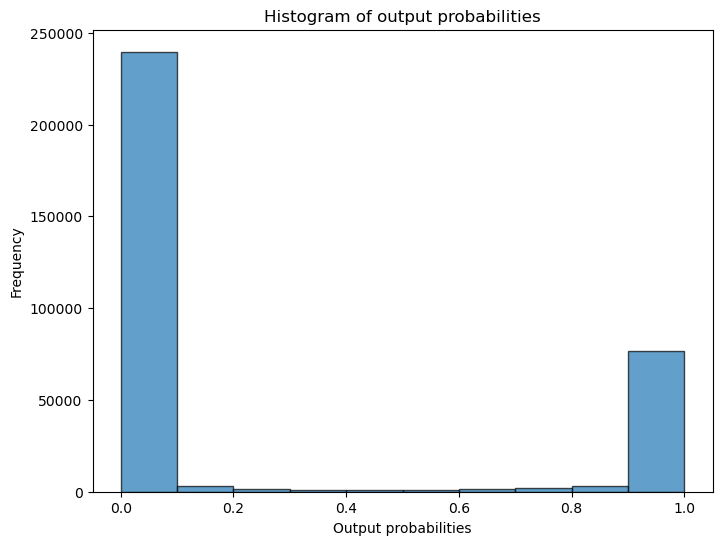

class1 = 3309 ; class0 = 3309 ; len(train_df) = 99
new non quanto 3309
new quanto 3309
324311 unlabeled peptides remaining
After concat: 6717
Retraining the model....

--- Epoch 1/20 ---

--- Epoch 2/20 ---

--- Epoch 3/20 ---

--- Epoch 4/20 ---

--- Epoch 5/20 ---

--- Epoch 6/20 ---

--- Epoch 7/20 ---

--- Epoch 8/20 ---

--- Epoch 9/20 ---

--- Epoch 10/20 ---

--- Epoch 11/20 ---

--- Epoch 12/20 ---

--- Epoch 13/20 ---

--- Epoch 14/20 ---

--- Epoch 15/20 ---

--- Epoch 16/20 ---

--- Epoch 17/20 ---

--- Epoch 18/20 ---

--- Epoch 19/20 ---

--- Epoch 20/20 ---


accuracy,▁
f1,▁
pr_auc,▁
precision,▁
recall,▁
roc_auc,▁
accuracy,0.54839
f1,0.41667
pr_auc,0.33377
precision,0.29412
recall,0.71429


0.5254265342500636 0.5252035002035002
New trained model is BETTER
1 iteration done with self training.

cvfold1_TopK_evo_hard_loss_praucstop__05


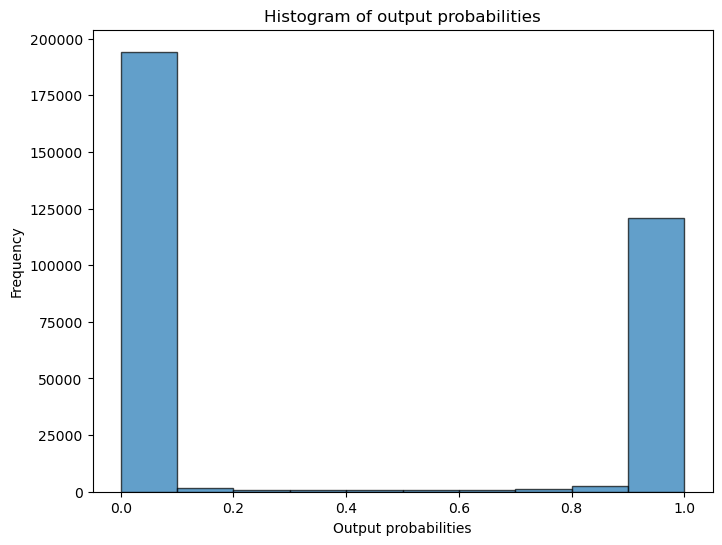

class1 = 16215 ; class0 = 16215 ; len(train_df) = 6717
new non quanto 16215
new quanto 16215
291881 unlabeled peptides remaining
After concat: 39147
Retraining the model....

--- Epoch 1/20 ---

--- Epoch 2/20 ---

--- Epoch 3/20 ---

--- Epoch 4/20 ---

--- Epoch 5/20 ---

--- Epoch 6/20 ---

--- Epoch 7/20 ---

--- Epoch 8/20 ---

--- Epoch 9/20 ---

--- Epoch 10/20 ---

--- Epoch 11/20 ---

--- Epoch 12/20 ---

--- Epoch 13/20 ---

--- Epoch 14/20 ---

--- Epoch 15/20 ---

--- Epoch 16/20 ---

--- Epoch 17/20 ---

--- Epoch 18/20 ---

--- Epoch 19/20 ---

--- Epoch 20/20 ---


accuracy,▁
f1,▁
pr_auc,▁
precision,▁
recall,▁
roc_auc,▁
accuracy,0.64516
f1,0.35294
pr_auc,0.3408
precision,0.3
recall,0.42857


0.487797619047619 0.5254265342500636
New trained model is not better
Fold 2 on 5
model filename: Best_BiLSTM_NES_N_O_cvfold2
Erreur pour la config dropout=0.2, n_layers=1, hidden_size=64, embedding_size=64.
Erreur pour la config dropout=0.2, n_layers=1, hidden_size=128, embedding_size=128.
Erreur pour la config dropout=0.2, n_layers=2, hidden_size=64, embedding_size=64.
Erreur pour la config dropout=0.2, n_layers=2, hidden_size=128, embedding_size=128.
Erreur pour la config dropout=0.2, n_layers=3, hidden_size=64, embedding_size=64.


accuracy,▁
f1,▁
pr_auc,▁
precision,▁
recall,▁
roc_auc,▁
accuracy,0.77419
f1,0.36364
pr_auc,0.6128
precision,0.5
recall,0.28571


{'accuracy': 0.76, 'precision': 0.5, 'recall': 0.16666666666666666, 'f1': 0.25, 'roc_auc': 0.7543859649122807, 'pr_auc': 0.6002284752284752}
331082
330929
cvfold2_TopK_evo_hard_loss_praucstop__01


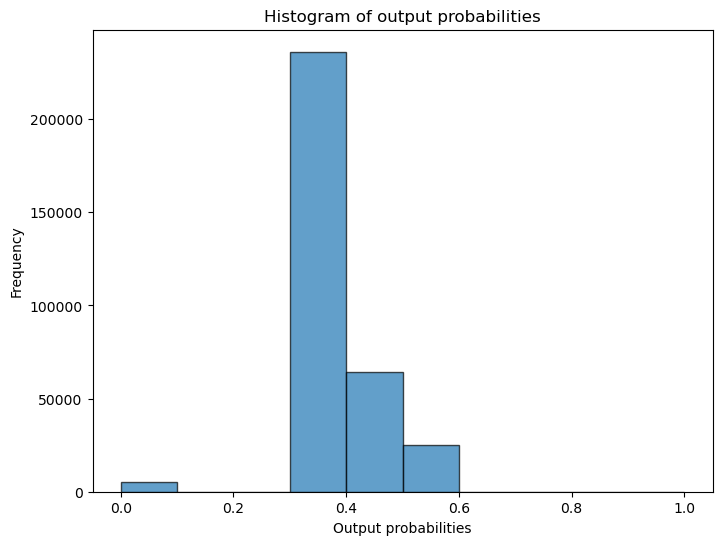

class1 = 3309 ; class0 = 3309 ; len(train_df) = 99
new non quanto 3309
new quanto 3309
324311 unlabeled peptides remaining
After concat: 6717
Retraining the model....

--- Epoch 1/20 ---

--- Epoch 2/20 ---

--- Epoch 3/20 ---

--- Epoch 4/20 ---

--- Epoch 5/20 ---

--- Epoch 6/20 ---

--- Epoch 7/20 ---

--- Epoch 8/20 ---

--- Epoch 9/20 ---

--- Epoch 10/20 ---

--- Epoch 11/20 ---

--- Epoch 12/20 ---

--- Epoch 13/20 ---

--- Epoch 14/20 ---

--- Epoch 15/20 ---

--- Epoch 16/20 ---

--- Epoch 17/20 ---

--- Epoch 18/20 ---

--- Epoch 19/20 ---

--- Epoch 20/20 ---


accuracy,▁
f1,▁
pr_auc,▁
precision,▁
recall,▁
roc_auc,▁
accuracy,0.77419
f1,0.53333
pr_auc,0.5127
precision,0.5
recall,0.57143


0.48928571428571427 0.6002284752284752
New trained model is not better
Fold 3 on 5
model filename: Best_BiLSTM_NES_N_O_cvfold3
Erreur pour la config dropout=0.2, n_layers=1, hidden_size=64, embedding_size=64.
Erreur pour la config dropout=0.2, n_layers=1, hidden_size=128, embedding_size=128.


accuracy,▁
f1,▁
pr_auc,▁
precision,▁
recall,▁
roc_auc,▁
accuracy,0.41935
f1,0.1
pr_auc,0.19345
precision,0.08333
recall,0.125


{'accuracy': 0.72, 'precision': 0.4444444444444444, 'recall': 0.6666666666666666, 'f1': 0.5333333333333333, 'roc_auc': 0.7719298245614036, 'pr_auc': 0.7045893719806763}
331082
330929
cvfold3_TopK_evo_hard_loss_praucstop__01


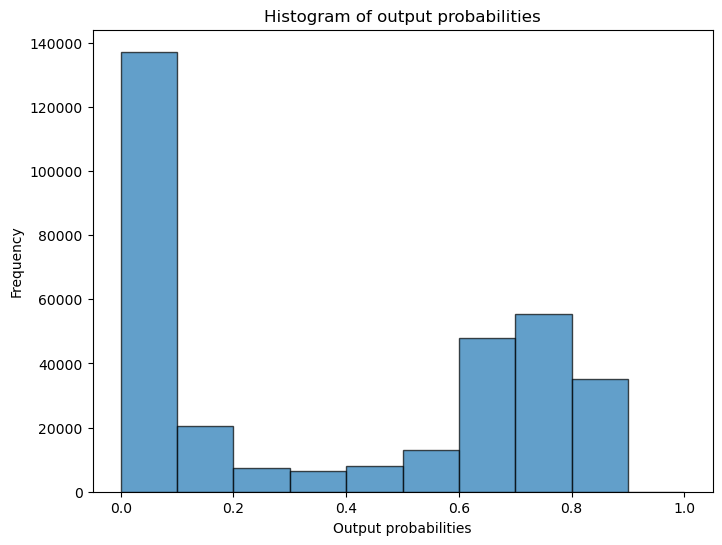

class1 = 3309 ; class0 = 3309 ; len(train_df) = 99
new non quanto 3309
new quanto 3309
324311 unlabeled peptides remaining
After concat: 6717
Retraining the model....

--- Epoch 1/20 ---

--- Epoch 2/20 ---

--- Epoch 3/20 ---

--- Epoch 4/20 ---

--- Epoch 5/20 ---

--- Epoch 6/20 ---

--- Epoch 7/20 ---

--- Epoch 8/20 ---

--- Epoch 9/20 ---

--- Epoch 10/20 ---

--- Epoch 11/20 ---

--- Epoch 12/20 ---

--- Epoch 13/20 ---

--- Epoch 14/20 ---

--- Epoch 15/20 ---

--- Epoch 16/20 ---

--- Epoch 17/20 ---

--- Epoch 18/20 ---

--- Epoch 19/20 ---

--- Epoch 20/20 ---


accuracy,▁
f1,▁
pr_auc,▁
precision,▁
recall,▁
roc_auc,▁
accuracy,0.51613
f1,0.0
pr_auc,0.20851
precision,0.0
recall,0.0


0.6175523349436393 0.7045893719806763
New trained model is not better
Fold 4 on 5
model filename: Best_BiLSTM_NES_N_O_cvfold4
Erreur pour la config dropout=0.2, n_layers=1, hidden_size=64, embedding_size=64.
Erreur pour la config dropout=0.2, n_layers=1, hidden_size=128, embedding_size=128.
Erreur pour la config dropout=0.2, n_layers=2, hidden_size=64, embedding_size=64.
Erreur pour la config dropout=0.2, n_layers=2, hidden_size=128, embedding_size=128.


accuracy,▁
f1,▁
pr_auc,▁
precision,▁
recall,▁
roc_auc,▁
accuracy,0.67742
f1,0.54545
pr_auc,0.5651
precision,0.42857
recall,0.75


{'accuracy': 0.6, 'precision': 0.25, 'recall': 0.3333333333333333, 'f1': 0.2857142857142857, 'roc_auc': 0.6140350877192983, 'pr_auc': 0.5241593567251461}
331082
330929
cvfold4_TopK_evo_hard_loss_praucstop__01


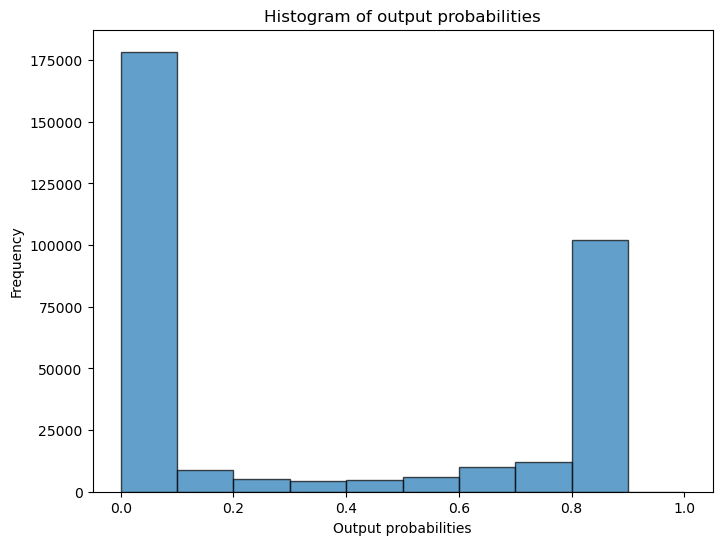

class1 = 3309 ; class0 = 3309 ; len(train_df) = 99
new non quanto 3309
new quanto 3309
324311 unlabeled peptides remaining
After concat: 6717
Retraining the model....

--- Epoch 1/20 ---

--- Epoch 2/20 ---

--- Epoch 3/20 ---

--- Epoch 4/20 ---

--- Epoch 5/20 ---

--- Epoch 6/20 ---

--- Epoch 7/20 ---

--- Epoch 8/20 ---

--- Epoch 9/20 ---

--- Epoch 10/20 ---

--- Epoch 11/20 ---

--- Epoch 12/20 ---

--- Epoch 13/20 ---

--- Epoch 14/20 ---

--- Epoch 15/20 ---

--- Epoch 16/20 ---

--- Epoch 17/20 ---

--- Epoch 18/20 ---

--- Epoch 19/20 ---

--- Epoch 20/20 ---


accuracy,▁
f1,▁
pr_auc,▁
precision,▁
recall,▁
roc_auc,▁
accuracy,0.74194
f1,0.6
pr_auc,0.5526
precision,0.5
recall,0.75


0.5318376068376068 0.5241593567251461
New trained model is BETTER
1 iteration done with self training.

cvfold4_TopK_evo_hard_loss_praucstop__05


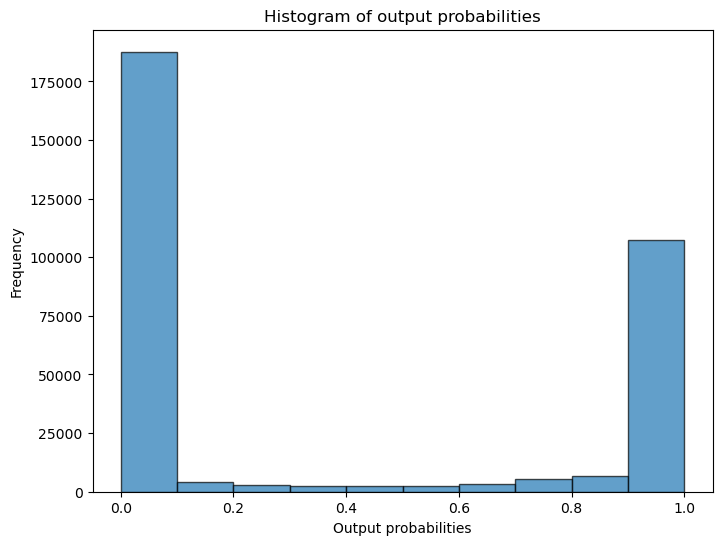

class1 = 16215 ; class0 = 16215 ; len(train_df) = 6717
new non quanto 16215
new quanto 16215
291881 unlabeled peptides remaining
After concat: 39147
Retraining the model....

--- Epoch 1/20 ---

--- Epoch 2/20 ---

--- Epoch 3/20 ---

--- Epoch 4/20 ---

--- Epoch 5/20 ---

--- Epoch 6/20 ---

--- Epoch 7/20 ---

--- Epoch 8/20 ---

--- Epoch 9/20 ---

--- Epoch 10/20 ---

--- Epoch 11/20 ---

--- Epoch 12/20 ---

--- Epoch 13/20 ---

--- Epoch 14/20 ---

--- Epoch 15/20 ---

--- Epoch 16/20 ---

--- Epoch 17/20 ---

--- Epoch 18/20 ---

--- Epoch 19/20 ---

--- Epoch 20/20 ---


accuracy,▁
f1,▁
pr_auc,▁
precision,▁
recall,▁
roc_auc,▁
accuracy,0.74194
f1,0.5
pr_auc,0.673
precision,0.5
recall,0.5


0.5464988228146123 0.5318376068376068
New trained model is BETTER
2 iteration done with self training.

cvfold4_TopK_evo_hard_loss_praucstop__10


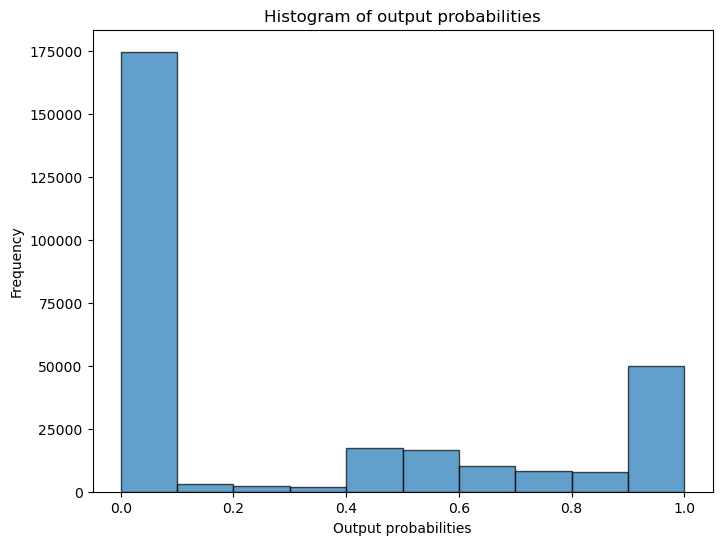

class1 = 29188 ; class0 = 29188 ; len(train_df) = 39147
new non quanto 29188
new quanto 29188
233505 unlabeled peptides remaining
After concat: 97523
Retraining the model....

--- Epoch 1/20 ---

--- Epoch 2/20 ---

--- Epoch 3/20 ---

--- Epoch 4/20 ---

--- Epoch 5/20 ---

--- Epoch 6/20 ---

--- Epoch 7/20 ---

--- Epoch 8/20 ---

--- Epoch 9/20 ---

--- Epoch 10/20 ---

--- Epoch 11/20 ---

--- Epoch 12/20 ---

--- Epoch 13/20 ---

--- Epoch 14/20 ---

--- Epoch 15/20 ---

--- Epoch 16/20 ---

--- Epoch 17/20 ---

--- Epoch 18/20 ---

--- Epoch 19/20 ---

--- Epoch 20/20 ---


accuracy,▁
f1,▁
pr_auc,▁
precision,▁
recall,▁
roc_auc,▁
accuracy,0.67742
f1,0.5
pr_auc,0.59527
precision,0.41667
recall,0.625


0.5777629233511586 0.5464988228146123
New trained model is BETTER
3 iteration done with self training.

cvfold4_TopK_evo_hard_loss_praucstop__20


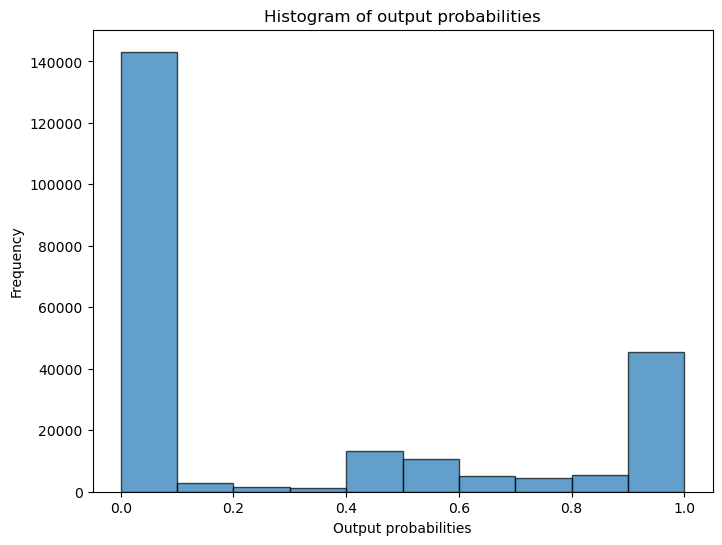

class1 = 46701 ; class0 = 46701 ; len(train_df) = 97523
new non quanto 46701
new quanto 46701
140103 unlabeled peptides remaining
After concat: 190925
Retraining the model....

--- Epoch 1/20 ---

--- Epoch 2/20 ---

--- Epoch 3/20 ---

--- Epoch 4/20 ---

--- Epoch 5/20 ---

--- Epoch 6/20 ---

--- Epoch 7/20 ---

--- Epoch 8/20 ---

--- Epoch 9/20 ---

--- Epoch 10/20 ---

--- Epoch 11/20 ---

--- Epoch 12/20 ---

--- Epoch 13/20 ---

--- Epoch 14/20 ---

--- Epoch 15/20 ---

--- Epoch 16/20 ---

--- Epoch 17/20 ---

--- Epoch 18/20 ---

--- Epoch 19/20 ---

--- Epoch 20/20 ---


accuracy,▁
f1,▁
pr_auc,▁
precision,▁
recall,▁
roc_auc,▁
accuracy,0.64516
f1,0.52174
pr_auc,0.67977
precision,0.4
recall,0.75


0.36725427350427353 0.5777629233511586
New trained model is not better
Fold 5 on 5
model filename: Best_BiLSTM_NES_N_O_cvfold5


accuracy,▁
f1,▁
pr_auc,▁
precision,▁
recall,▁
roc_auc,▁
accuracy,0.67742
f1,0.16667
pr_auc,0.35702
precision,0.25
recall,0.125


{'accuracy': 0.8, 'precision': 0.6, 'recall': 0.5, 'f1': 0.5454545454545454, 'roc_auc': 0.8771929824561403, 'pr_auc': 0.7346611721611721}
331082
330929
cvfold5_TopK_evo_hard_loss_praucstop__01


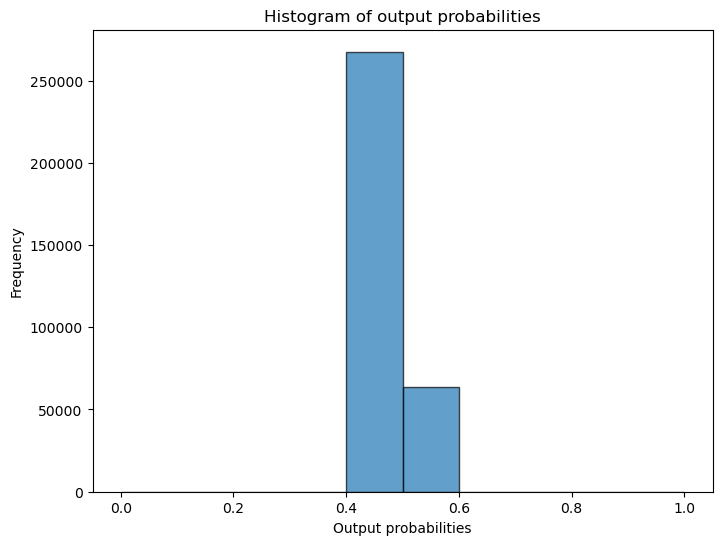

class1 = 3309 ; class0 = 3309 ; len(train_df) = 99
new non quanto 3309
new quanto 3309
324311 unlabeled peptides remaining
After concat: 6717
Retraining the model....

--- Epoch 1/20 ---

--- Epoch 2/20 ---

--- Epoch 3/20 ---

--- Epoch 4/20 ---

--- Epoch 5/20 ---

--- Epoch 6/20 ---

--- Epoch 7/20 ---

--- Epoch 8/20 ---

--- Epoch 9/20 ---

--- Epoch 10/20 ---

--- Epoch 11/20 ---

--- Epoch 12/20 ---

--- Epoch 13/20 ---

--- Epoch 14/20 ---

--- Epoch 15/20 ---

--- Epoch 16/20 ---

--- Epoch 17/20 ---

--- Epoch 18/20 ---

--- Epoch 19/20 ---

--- Epoch 20/20 ---


accuracy,▁
f1,▁
pr_auc,▁
precision,▁
recall,▁
roc_auc,▁
accuracy,0.74194
f1,0.0
pr_auc,0.3361
precision,0.0
recall,0.0


0.2713804713804714 0.7346611721611721
New trained model is not better


accuracy_mean,▁
accuracy_std,▁
f1_mean,▁
f1_std,▁
pr_auc_mean,▁
pr_auc_std,▁
precision_mean,▁
precision_std,▁
recall_mean,▁
recall_std,▁
roc_auc_mean,▁


In [ ]:
LEARNING_RATE = 3e-4
VOCAB_SIZE = len(amino_acid_vocab) + 1  # +1 for padding
EMBED_DIM = 128
HIDDEN_DIM = 128
OUTPUT_DIM = 1
BATCH_SIZE = 32
LSTM_LAYERS = 2
LSTM_HIDDEN_DIM = 32
N_EPOCHS = 100
N_SPLITS = 5
DROPOUT = 0.3

# Define paths and useful variables
count = 1
do_early_stopping = False
weighting = False
oversampling = True
FT = None
device = "cuda" if torch.cuda.is_available() else "cpu"
models_path = "/home/jwalraff/TFE/Models"
results_path = "/home/jwalraff/TFE/Results"
images_path = "/home/jwalraff/TFE/Images"

imbalanced_name_dict = {
    "Imbalance": {
        (False, False): "N",
        (True, False): "W",
        (False, True): "O"
    },
    "Early Stopping": {
        True: "ES",
        False: "NES"
    },
    "Transfer Learning": {
        True: "FT",
        False: "FE",
        None: "N"
    }
}

kf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

# Configuration of the self-training
temp_results_list = []
threshold = 0.7 # 0.5 ; 0.7 ; 0.9 ; 0.95 ; 0.99
pl_method = "TopK evo" # fixed ; TopK fixed ; TopK evo ; optimal roc ; optimal pr
percentage_evo = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
fixed_percentage = 0.05 # 0.05 ; 0.01 ; 0.001
max_number_of_iterations = 5
best_thr = 0.0
hard_or_soft = "hard_loss" # hard_loss ; soft_loss
use_double_loss = False
alpha = 0.5
pr_auc_stopping_criterion = True
    

# Loop over the folds
for fold, (train_idx, test_idx) in enumerate(kf.split(df, df['quantotypic'])):
    # if fold < 2:
    #   print(f"Skipping fold {fold}")
    #   continue

    print(f"Fold {fold+1} on 5")
    evolution_list = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'roc_auc': [],
        'pr_auc': []
    }
    pseudo_label_instance_list = []

    # Recreate the model name and extract the hyperparameters
    model_fname = f"Best_BiLSTM_{imbalanced_name_dict['Early Stopping'][do_early_stopping]}_{imbalanced_name_dict['Transfer Learning'][FT]}_{imbalanced_name_dict['Imbalance'][(weighting, oversampling)]}_cvfold{fold+1}"
    print(f"model filename: {model_fname}")
    dropout, n_layers, hidden_size, embedding_size = find_BiLSTM_param(f"{models_path}/{model_fname}.pth")

    # Load the model with the found parameters
    model = PeptideBiLSTMClassifier(VOCAB_SIZE, embedding_size, hidden_size, hidden_size, OUTPUT_DIM, dropout, n_layers)
    model.load_state_dict(torch.load(f"{models_path}/{model_fname}.pth"))

    # Split the data and create dataloaders
    tmp_train_df = df.iloc[train_idx]
    test_df = df.iloc[test_idx]

    train_df, val_df = train_test_split(tmp_train_df, test_size=0.2, stratify=tmp_train_df['quantotypic'], random_state=42)

    if oversampling:
        train_df = utils.balance_classes_with_oversampling(train_df)

    train_dataset = PeptideDataset(train_df['sequence'].values, train_df['quantotypic'].values, train_df["pseudo_label"].values, amino_acid_vocab, max_len)
    val_dataset = PeptideDataset(val_df['sequence'].values, val_df['quantotypic'].values, train_df["pseudo_label"].values, amino_acid_vocab, max_len)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    validation_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

    pos_weight = compute_pos_weight(train_df, 'quantotypic') if weighting else None
    
    test_dataset = PeptideDataset(test_df['sequence'].values, test_df['quantotypic'].values, test_df["pseudo_label"].values, amino_acid_vocab, max_len)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    # Evaluate the model on the test set
    results = evaluate_bilstm_model(model, test_loader, f"{images_path}/SelfTraining/BiLSTM/BiLSTMOutputProbabilities_fold{fold+1}", plot=False)
    
    wandb.init(project="BiLSTM", name=f"SelfTraining_BiLSTM_Scratch_cvfold{fold+1}_iter0",
                config={
                    "weighting": weighting,
                    "oversampling": oversampling,
                    "early_stopping": do_early_stopping,
                    "method" : pl_method,
                    "Threshold": threshold if 'fixed' in pl_method else best_thr,
                    "Percentage": None,
                    "n_epoch": None,
                    "LR": None,
                    "Max iter": max_number_of_iterations,
                    "Hard or soft": hard_or_soft,
                    "Double loss": use_double_loss,
                    "Alpha": alpha
                })

    wandb.log(results)
    wandb.finish()

    evolution_list['accuracy'].append(results['accuracy'])
    evolution_list['precision'].append(results['precision'])
    evolution_list['recall'].append(results['recall'])
    evolution_list['f1'].append(results['f1'])
    evolution_list['roc_auc'].append(results['roc_auc'])
    evolution_list['pr_auc'].append(results['pr_auc'])

    best_model = model
    best_history = evaluate_bilstm_model(model, validation_loader, f"{images_path}/SelfTraining/BiLSTM/BiLSTMOutputProbabilities_fold{fold+1}", plot=False)
    print(best_history)
    
    n_epoch = 20
    LR = 3e-4
    BATCH_SIZE = 256

    # Process the unlabeled data => remove the sequences that are already in the train, test, and val datasets
    unlabeled_peptide = unique_peptide

    print(len(unlabeled_peptide))
    sequences_to_remove = set(train_df["sequence"]).union(set(test_df["sequence"])).union(set(val_df["sequence"]))
    unlabeled_peptide = unlabeled_peptide[~unlabeled_peptide.isin(sequences_to_remove)]
    print(len(unlabeled_peptide))

    iter = 1

    # Start of the self-training
    while True:
        # If there are no unlabeled peptides left, break the loop
        if len(unlabeled_peptide) == 0:
            print("All unlabeled peptide have been used")
            break

        # Update the percentage for the TopK evo method
        if pl_method == "TopK evo":
            percentage = percentage_evo[iter-1]
            if percentage > 0.5:
                print("Percentage value exceed 0.5")
                break

        # Break the loop if the maximum number of iterations is reached
        if pl_method == "TopK fixed":
            percentage = fixed_percentage
            if iter > max_number_of_iterations:
                print("Max number of iterations reached")
                break
        
        # Find the optimal threshold for the pseudo-labeling generation
        if 'optimal' in pl_method:
            best_thr = find_optimal_probability_threshold(model, validation_loader, device, 'roc' if 'roc' in pl_method else 'pr')
            best_thr = round(best_thr, 3)
            print("Best threshold", best_thr)

        tmp_pl_method = pl_method.replace(" ", "_")

        # Create the filename for saving the results
        if pl_method == "fixed":
            partof_filename = f"cvfold{fold+1}_{tmp_pl_method}_{hard_or_soft}{f'_praucstop_' if pr_auc_stopping_criterion else ''}{f'_double_loss_{alpha * 100:02.0f}' if use_double_loss else ''}_{threshold * 100:02.0f}"
            v = threshold
        elif pl_method == "TopK evo":
            partof_filename = f"cvfold{fold+1}_{tmp_pl_method}_{hard_or_soft}{f'_praucstop_' if pr_auc_stopping_criterion else ''}{f'_double_loss_{alpha * 100:02.0f}' if use_double_loss else ''}_{percentage * 100:02.0f}"
            v = percentage
        elif pl_method == "TopK fixed":
            partof_filename = f"cvfold{fold+1}_{tmp_pl_method}_{hard_or_soft}{f'_praucstop_' if pr_auc_stopping_criterion else ''}{f'_double_loss_{alpha * 100:02.0f}' if use_double_loss else ''}_{percentage * 100:02.0f}_Maxiter{max_number_of_iterations}"
            v = percentage
        elif 'optimal' in pl_method:
            partof_filename = f"cvfold{fold+1}_{tmp_pl_method}_{hard_or_soft}{f'_praucstop_' if pr_auc_stopping_criterion else ''}{f'_double_loss_{alpha * 100:02.0f}' if use_double_loss else ''}"
            v = best_thr
        print(partof_filename)

        # Create the unlabeled dataset and dataloader
        tmp_label = np.zeros(len(unlabeled_peptide))
        tmp_ps = np.full(len(unlabeled_peptide), True, dtype=bool)

        unlabeled_dataset = PeptideDataset(unlabeled_peptide.values, tmp_label, tmp_ps, amino_acid_vocab, max_len)
        unlabeled_dataloader = DataLoader(unlabeled_dataset, batch_size=256, shuffle=False)

        # Generate probabilities on unlabeled data
        outputs_probabilities = []
        for x, y, _ in unlabeled_dataloader:
          x, y = x.to(device), y.to(device)
          output = model(x)
          outputs_probabilities.append(torch.sigmoid(output).cpu().detach().numpy())

        outputs_probabilities = np.concatenate(outputs_probabilities).flatten()
        plot_probabilities(outputs_probabilities, f"{images_path}/SelfTraining/BiLSTM/BiLSTMOutputProbabilities_iter{iter}_{partof_filename}.png")

        # Generate pseudo-labels based on the probabilities
        class1, class0 = generate_pseudo_labels(outputs_probabilities, method=pl_method, value=v)
        train_df = train_df.drop_duplicates(subset="sequence", keep="first")
        class1_sum, class0_sum = class1.sum(), class0.sum()

        print(f"class1 = {class1_sum} ; class0 = {class0_sum} ; len(train_df) = {len(train_df)}")

        pseudo_label_instance_list.append((class0_sum, class1_sum))

        # If too few pseudo-labels are generated, break the loop
        if (pl_method == "fixed" or 'optimal' in pl_method) and class1_sum + class0_sum < 0.01 * len(train_df):
          print("No new pseudo label can be generated")
          break

        # Delete the pseudo-labeled peptides from the unlabeled dataset
        new_nonquanto = unlabeled_peptide[class1]
        new_quanto = unlabeled_peptide[class0]
        print(f"new non quanto {len(new_nonquanto)}")
        print(f"new quanto {len(new_quanto)}")

        delete_pseudo_labeled_peptide = class1 | class0

        unlabeled_peptide = unlabeled_peptide[~delete_pseudo_labeled_peptide]
        print(f"{len(unlabeled_peptide)} unlabeled peptides remaining")

        # Create a new dataframe with the pseudo-labeled peptides
        if hard_or_soft == "hard_loss":
            new_nonquanto = pd.DataFrame({"sequence": new_nonquanto, "quantotypic": 1, "pseudo_label": True})
            new_quanto = pd.DataFrame({"sequence": new_quanto, "quantotypic": 0, "pseudo_label": True})
        else:
            print("soft_loss")
            new_nonquanto = pd.DataFrame({"sequence": new_nonquanto, "quantotypic": outputs_probabilities[class1], "pseudo_label": True})
            new_quanto = pd.DataFrame({"sequence": new_quanto, "quantotypic": outputs_probabilities[class0], "pseudo_label": True})

        # Update the training set
        train_df = pd.concat([train_df, new_nonquanto, new_quanto], ignore_index=True)

        print(f"After concat: {len(train_df)}")

        if oversampling:
            train_df = utils.balance_classes_with_oversampling(train_df, loss_type = "hard" if hard_or_soft == "hard_loss" else "soft")

        pos_weight = compute_pos_weight(train_df, 'quantotypic') if weighting else None

        # Recreate the dataloader with the new training set
        train_dataset = PeptideDataset(train_df['sequence'].values, train_df['quantotypic'].values, train_df["pseudo_label"].values, amino_acid_vocab, max_len)
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

        # Retrain the model with the new training set
        print(f"Retraining the model....")
        history = train(model, train_loader, validation_loader, n_epoch, LR, do_early_stopping=do_early_stopping,
                                            model_name='Scratch', weight=pos_weight, verbose=True, use_double_loss=use_double_loss, alpha=alpha)

        # Evaluate the model on the test set
        results = evaluate_bilstm_model(model, test_loader, f"{images_path}/SelfTraining/BiLSTM/BiLSTMOutputProbabilities_iter{iter}_{partof_filename}", plot=False)

        evolution_list['accuracy'].append(results['accuracy'])
        evolution_list['precision'].append(results['precision'])
        evolution_list['recall'].append(results['recall'])
        evolution_list['f1'].append(results['f1'])
        evolution_list['roc_auc'].append(results['roc_auc'])
        evolution_list['pr_auc'].append(results['pr_auc'])

        wandb.init(project="BiLSTM", name=f"SelfTraining_BiLSTM_Scratch_cvfold{fold+1}_iter{iter}",
                    config={
                        "weighting": weighting,
                        "oversampling": oversampling,
                        "early_stopping": do_early_stopping,
                        "method" : pl_method,
                        "Threshold": threshold if 'fixed' in pl_method else best_thr,
                        "Percentage": percentage if pl_method == "TopK fixed" else None,
                        "n_epoch": n_epoch,
                        "LR": LR,
                        "Max iter": max_number_of_iterations,
                        "Hard or soft": hard_or_soft,
                        "Double loss": use_double_loss,
                        "Alpha": alpha
                    })

        wandb.log(results)
        wandb.finish()

        if pr_auc_stopping_criterion:
            best_model, best_history, better_bool = compute_best(history, best_history, model, best_model)

            if not better_bool:
                print("New trained model is not better")
                break
            else:
                print("New trained model is BETTER")
                best_model = model
                best_history = history
        else:
            best_model = model
            best_history = history

        print(f"{iter} iteration done with self training.\n")
        iter = iter + 1

    torch.save(best_model.state_dict(), f"{models_path}/SelfTraining/BiLSTM/BestST_BiLSTM_Scratch_{partof_filename}.pth")

    self_training_results = {
        'accuracy': results['accuracy'],
        'precision': results['precision'],
        'recall': results['recall'],
        'f1': results['f1'],
        'roc_auc': results['roc_auc'],
        'pr_auc': results['pr_auc']
    }

    temp_results_list.append(self_training_results)

    write_into_json(evolution_list, f"{results_path}/SelfTraining/BiLSTM/SelfTraining_BiLSTM_Evolution_{partof_filename}.json")
    write_into_json(self_training_results, f"{results_path}/SelfTraining/BiLSTM/SelfTraining_BiLSTM_Results_{partof_filename}.json")

    plot_pl_instances(pseudo_label_instance_list, f"{images_path}/SelfTraining/BiLSTM/PseudoLabelInstances_{partof_filename}")


accuracy_list = [res['accuracy'] for res in temp_results_list]
precision_list = [res['precision'] for res in temp_results_list]
recall_list = [res['recall'] for res in temp_results_list]
f1_list = [res['f1'] for res in temp_results_list]
roc_auc_list = [res['roc_auc'] for res in temp_results_list]
pr_auc_list = [res['pr_auc'] for res in temp_results_list]

# Calcul des moyennes et écarts-types
metrics_summary = {
    'accuracy_mean': np.mean(accuracy_list),
    'accuracy_std': np.std(accuracy_list),
    'precision_mean': np.mean(precision_list),
    'precision_std': np.std(precision_list),
    'recall_mean': np.mean(recall_list),
    'recall_std': np.std(recall_list),
    'f1_mean': np.mean(f1_list),
    'f1_std': np.std(f1_list),
    'roc_auc_mean': np.mean(roc_auc_list),
    'roc_auc_std': np.std(roc_auc_list),
    'pr_auc_mean': np.mean(pr_auc_list),
    'pr_auc_std': np.std(pr_auc_list),
}

wandb.init(project="BiLSTM", name=f"SelfTraining_BiLSTM_Scratch_Summary",
            config={
                "weighting": weighting,
                "oversampling": oversampling,
                "early_stopping": do_early_stopping,
                "method" : pl_method,
                "Threshold": threshold if 'fixed' in pl_method else best_thr,
                "Percentage": percentage if pl_method == "TopK fixed" else None,
                "n_epoch": n_epoch,
                "LR": LR,
                "Max iter": max_number_of_iterations,
                "Hard or soft": hard_or_soft,
                "Double loss": use_double_loss,
                "Alpha": alpha
            })

wandb.log(metrics_summary)
wandb.finish()

dict_save = {
    'weighting': weighting,
    'oversampling': oversampling,
    'early_stopping': do_early_stopping,
    'method': pl_method,
    "Threshold": threshold if 'fixed' in pl_method else best_thr,
    "Hard or soft": hard_or_soft,
    "Double loss": use_double_loss,
    "Alpha": alpha,
    'metrics': metrics_summary
}

if pl_method == "fixed":
    final_filename = f"{tmp_pl_method}_{hard_or_soft}{f'_praucstop_' if pr_auc_stopping_criterion else ''}{f'_double_loss_{alpha * 100:02.0f}' if use_double_loss else ''}_{threshold * 100:02.0f}"
elif "TopK" in pl_method:
    final_filename = f"{tmp_pl_method}_{hard_or_soft}{f'_praucstop_' if pr_auc_stopping_criterion else ''}{f'_double_loss_{alpha * 100:02.0f}' if use_double_loss else ''}_{percentage * 100:02.0f}"
else:
    final_filename = f"{tmp_pl_method}_{hard_or_soft}{f'_praucstop_' if pr_auc_stopping_criterion else ''}{f'_double_loss_{alpha * 100:02.0f}' if use_double_loss else ''}"

write_into_json(dict_save, f"{results_path}/SelfTraining/BiLSTM/SelfTraining_BiLSTM_CVSummary_{final_filename}.json")
count += 1